In [2]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

In [3]:
# read the data sets
df = pd.read_csv('../data/clean_HR_Analytics.csv')

#### Split

In [4]:
# vertical split
target = "Attrition"
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Build

In [4]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(random_state=42)
)

In [12]:
params = {
    "randomforestclassifier__n_estimators": range(50, 110, 5),
    "randomforestclassifier__max_depth": range(10, 50, 5)
}

In [13]:
model = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 110, 5)},
             verbose=1)

In [14]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 110, 5)},
             verbose=1)

In [43]:
cv_result = pd.DataFrame(model.cv_results_)
cv_result.head(6)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.350243,0.038585,0.051918,0.007936,10,25,"{'randomforestclassifier__max_depth': 10, 'ran...",0.855932,0.863830,0.842553,0.834043,0.863830,0.852038,0.011892,8
1,0.531362,0.107765,0.065404,0.012830,10,50,"{'randomforestclassifier__max_depth': 10, 'ran...",0.855932,0.863830,0.846809,0.855319,0.863830,0.857144,0.006341,1
2,0.584546,0.081363,0.065618,0.016734,10,75,"{'randomforestclassifier__max_depth': 10, 'ran...",0.855932,0.872340,0.846809,0.846809,0.863830,0.857144,0.009907,1
3,0.365090,0.034208,0.054259,0.006850,20,25,"{'randomforestclassifier__max_depth': 20, 'ran...",0.855932,0.863830,0.846809,0.838298,0.855319,0.852038,0.008731,9
4,0.440502,0.044383,0.057727,0.006640,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",0.851695,0.859574,0.842553,0.855319,0.846809,0.851190,0.006023,12
5,0.581108,0.062009,0.063573,0.008910,20,75,"{'randomforestclassifier__max_depth': 20, 'ran...",0.860169,0.876596,0.846809,0.846809,0.855319,0.857140,0.010995,3


In [15]:
# Extract the best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 95}

#### Evaluate

In [16]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training Accuracy: ", round(train_acc, 2))
print("Test Accuracy: ", round(test_acc, 2))

Training Accuracy:  1.0
Test Accuracy:  0.87


##### Plot Confusion Matrix

In [10]:
# generate the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[250,   5],
       [ 34,   5]])

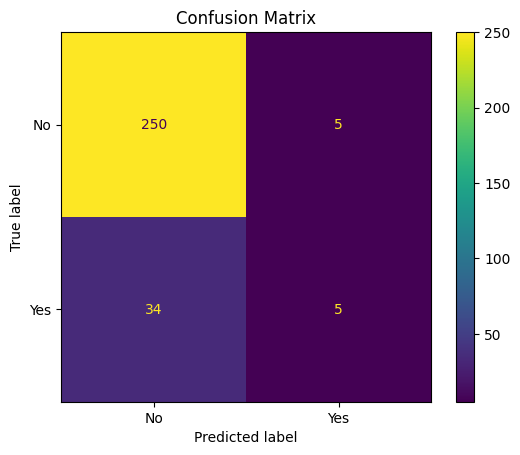

In [11]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot the confusion matrix
cm_display.plot() 
plt.title("Confusion Matrix");
plt.savefig('../reports/confusion_matrix_RF.jpg')

#### Communicate

In [18]:
# get feature names
features = model.best_estimator_.named_steps["onehotencoder"].get_feature_names_out()
# Extract the importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# create a series
features_imp = pd.Series(importances, index=features).sort_values()

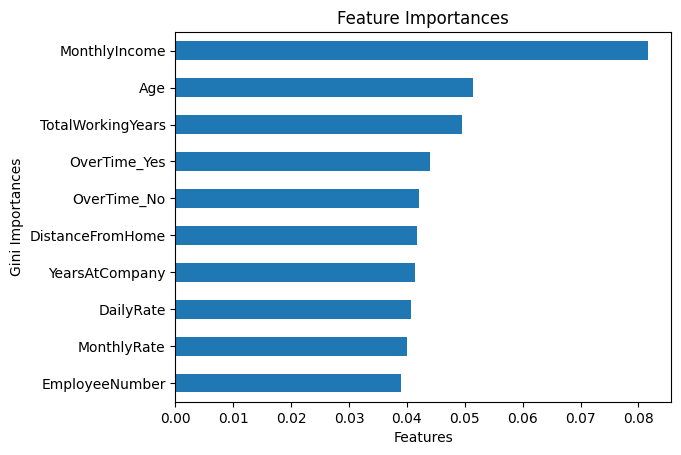

In [62]:
features_imp.tail(10).plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importances")
plt.title("Feature Importances");

#### Save the Model

In [70]:
timestamp = pd.Timestamp.now().replace(microsecond=0).isoformat()
file_path = os.path.join('../models', f'{timestamp}_RF.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(model, f)